WARNING: **install development dependencies** before running this notebook either with
```bash
$ conda install --file requirements_dev.txt -c conda-forge
# or with
$ pip install -r requirements_dev.txt
```

In [1]:
%matplotlib inline

# ensure that any edits to libraries
# are reloaded automatically
%reload_ext autoreload
%autoreload 2

In [2]:
# make cuda_slic importable
import sys
sys.path.append("./../src/")

lets import the relavent functions

In [3]:
from cuda_slic.slic import slic as cuda_slic

In [4]:
import numpy as np
from skimage import data, color, filters, segmentation
from skimage.util import img_as_float32, img_as_float64
from skimage.segmentation import slic as sk_slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
from ipywidgets import interact

## Segmenting 2D images

In [5]:
def plot_images(images, cols=2, ax_size=5, titles=None):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*ax_size, rows*ax_size))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i in range(len(images)):
        axes[i].imshow(images[i])
        if titles:
            axes[i].set_title(titles[i], size=32)
    plt.tight_layout()

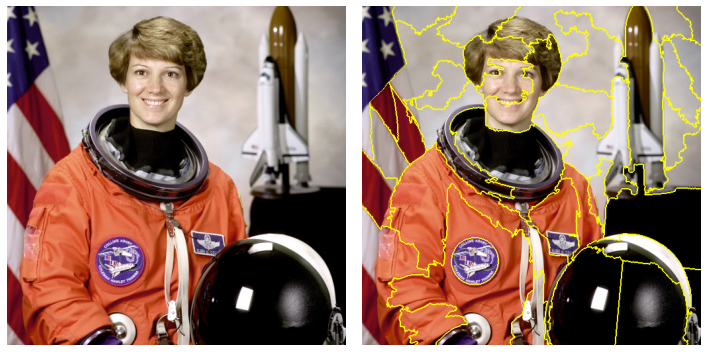

In [6]:
astro = data.astronaut()
labels = cuda_slic(astro, multichannel=True)
marked_astro = mark_boundaries(astro, labels)
plot_images([astro, marked_astro])

In [7]:
astro = data.astronaut()
def compare_slics_2d(cuda_c, sk_c, max_iter=5, n_segments=20):
    global astro
    cuda_labels = cuda_slic(astro, 
                            n_segments=n_segments,
                            compactness=cuda_c,
                            max_iter=max_iter,
                            multichannel=True,
                            enforce_connectivity=True)
    sk_labels = sk_slic(astro, 
                        n_segments=n_segments,
                        compactness=sk_c,
                        multichannel=True,
                        start_label=0)
    marked_astro_cuda = mark_boundaries(astro, cuda_labels, color=(0.2, 1, 0))
    marked_astro_sk = mark_boundaries(astro, sk_labels, color=(1, 0.7, 0))
    images = [cuda_labels, marked_astro_cuda, sk_labels, marked_astro_sk]
    plot_images(images, ax_size=5)
    print("cuda unique labels = {}".format(len(np.unique(cuda_labels))))
    print("sk unique labels = {}".format(len(np.unique(sk_labels))))

In [8]:
from ipywidgets import interact, IntSlider
interact(compare_slics_2d,
         cuda_c=(0.001,1.0,0.001),
         sk_c=(0.001,1.0,0.0001),
         n_segments=(0,500),
        );

interactive(children=(FloatSlider(value=0.5, description='cuda_c', max=1.0, min=0.001, step=0.001), FloatSlide…

## Segmenting 3D images

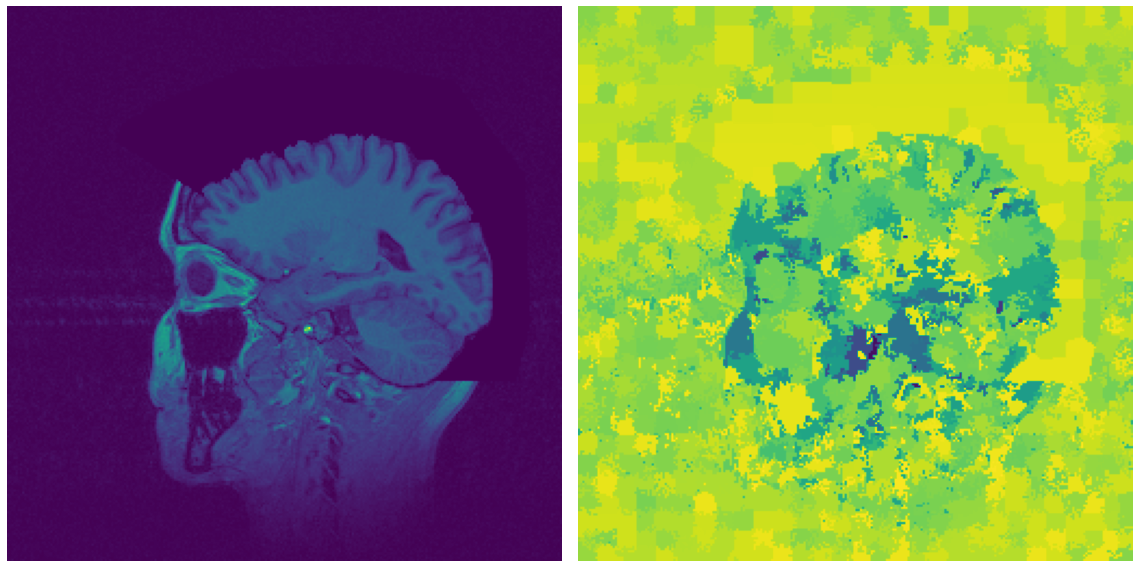

In [9]:
import h5py as h5
with h5.File('../data/brain.h5', 'r') as f:
    brain = f['/data'][()] # 3D single channel

labels = cuda_slic(brain,
                 n_segments=10000,
                 multichannel=False,
                 compactness=0.09,
                 max_size_factor=10,
                 min_size_factor=0.1)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.imshow(brain[40]); ax2.imshow(labels[40])
ax1.axis('off'); ax2.axis('off')
plt.tight_layout()

## Comparing skimage_slic with cuda_slic

In [10]:
def plot_slice(images, z, cols=2, ax_size=5, titles=None):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*ax_size, rows*ax_size))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i in range(len(images)):
        axes[i].imshow(images[i][:,:,z])
        if titles:
            axes[i].set_title(titles[i], size=32)
    plt.tight_layout()

In [11]:
n = 200
blob = data.binary_blobs(length=n, n_dim=3, seed=2)[...,:10]
def compare_slics_3d(cuda_c, sk_c, max_iter=5, n_segments=20, z=0):
    global blob
    cuda_labels = cuda_slic(blob, n_segments=n_segments,
                            compactness=cuda_c,
                            multichannel=False,
                            max_iter=max_iter)
    sk_labels = sk_slic(blob, n_segments=n_segments,
                        compactness=sk_c,
                        multichannel=False,
                        start_label=1)
    plot_slice([cuda_labels, blob, sk_labels, blob],
               z=z,
               ax_size=5,
               titles=["cuda-slic", "data", "skimage-slic", "data"])
    print("cuda unique labels = {}".format(len(np.unique(cuda_labels))))
    print("sk unique labels = {}".format(len(np.unique(sk_labels))))

In [12]:
from ipywidgets import IntSlider, fixed
interact(compare_slics_3d,
         
         cuda_c=(0.001,1.0,0.001),
         sk_c=(0.001,1.0,0.0001),
         n_segments=(0,500),
         z=IntSlider(min=0, max=9));

interactive(children=(FloatSlider(value=0.5, description='cuda_c', max=1.0, min=0.001, step=0.001), FloatSlide…

## Performance Benchmarks
###  Simple Benchmark

In [13]:
from skimage import data
from cuda_slic.slic import slic as cuda_slic
from skimage.segmentation import slic as sk_slic

n = 200
superpixel_side = 5 # super pixel shape of (5,5,5)
blob = data.binary_blobs(length=n, n_dim=3, seed=2)
n_segments = n**3/superpixel_side**3

In [14]:
skimage_time = %timeit -r1 -n1 -o sk_slic(blob,\
                                               n_segments=n_segments,\
                                               multichannel=False,\
                                               max_iter=5,\
                                               start_label=1)

9.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
cuda_time = %timeit -r1 -n1 -o cuda_slic(blob,\
                                         n_segments=n_segments,\
                                         multichannel=False,\
                                         max_iter=5)

767 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
input_size = n**3*4/10**9 #GB
print(f"skimage-slic time = {skimage_time.average}s")
print(f"cuda-slic time = {cuda_time.average}s")
print("cuda_slic is {:.2f}x faster than skimage_slic with {:.3f} GB image".format(\
        skimage_time.average/cuda_time.average, input_size))

skimage-slic time = 9.073459523031488s
cuda-slic time = 0.7672456509899348s
cuda_slic is 11.83x faster than skimage_slic with 0.032 GB image


## Comprehensive Benchmark

In [17]:
from pathlib import Path

# make `data` directory in notebooks if it does not exist
notebooks = Path(".")
dir_name = str(notebooks.absolute()).split("/")[-1]
if dir_name == "notebooks":
    (notebooks/"benchmarks").mkdir(exist_ok=True)
else:
    print("notebooks is not your current worknig directory")
[print(f) for f in notebooks.iterdir()];

.ipynb_checkpoints
exploring_slic3d.ipynb
benchmarks
exploring_slic_2d.ipynb
numpy_notes.ipynb
pycuda_debug.ipynb
exploring_slic.ipynb


In [20]:
import pandas as pd

In [21]:
DO_BENCHMARK = True
SAVE_BENCHMARK = False

def generate_benchmark():
    df = pd.DataFrame(columns=["bytes", "n_segments", "cuda_time", "skimage_time"])
    lengths = [100, 200, 300, 400, 500]
    #lengths = range(100, 450,30)
    for i in range(len(lengths)):
        row = []
        row.append(lengths[i]**3*4) #number of bytes to be processed
        n_segments = lengths[i]**3/3**3
        row.append(n_segments)
        blob = data.binary_blobs(length=lengths[i], n_dim=3, seed=2)
        blob = np.float32(blob)
        print(f"cuda time for length {lengths[i]}:")
        measurement1 = %timeit -n1 -r1 -o cuda_slic(blob, n_segments=n_segments, multichannel=False, compactness=1)
        row.append(measurement1.average)
        print(f"skimage time for length {lengths[i]}:")
        measurement2 = %timeit -n1 -r1 -o sk_slic(blob, n_segments=n_segments, \
                                                  compactness=1, multichannel=False, \
                                                  max_iter=5, start_label=1)
        row.append(measurement2.average)
        df.loc[i] = row
    return df
if DO_BENCHMARK:
    df = generate_benchmark()

cuda time for length 100:
151 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 100:
1.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 200:
803 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 200:
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 300:
2.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 300:
34.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 400:
5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 400:
1min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
cuda time for length 500:
9.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
skimage time for length 500:
2min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
print(df.skimage_time/df.cuda_time)

0     2.142904
1    20.495266
2    21.334586
3    21.925650
4    23.362116
dtype: float64


In [9]:
from datetime import datetime
SAVE_BENCHMARK = False
if SAVE_BENCHMARK:
    d = datetime.now()
    d = d.strftime("%d_%m_%Y")
    df.to_csv("benchmarks/slic_bench_{}.csv".format(d), index=False)

In [10]:
ndf = df.copy()

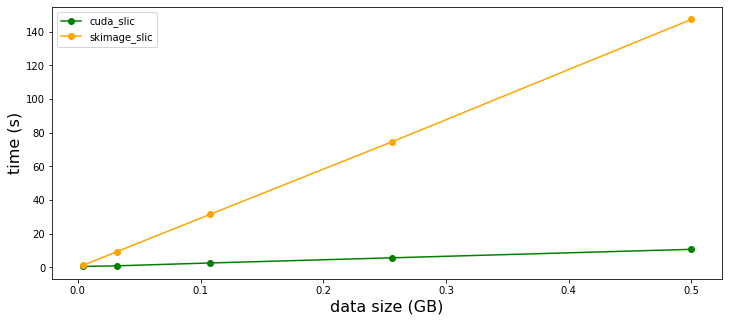

In [11]:
ndf["g_bytes"] = ndf["bytes"]/10**9

fig, ax = plt.subplots(1,1,figsize=(12,5))
plt.plot(ndf.g_bytes, ndf.cuda_time, color="green", marker="o", label="cuda_slic")

plt.plot(ndf.g_bytes, ndf.skimage_time, color="orange", marker="o", label="skimage_slic")
plt.xlabel("data size (GB)", size=16)
plt.ylabel("time (s)", size=16)
plt.legend()

In [12]:
slope_cuda = (ndf.cuda_time.iloc[-1] - ndf.cuda_time.iloc[0])/\
             (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])
slope_skimage = (ndf.skimage_time.iloc[-1] - ndf.skimage_time.iloc[0])/\
                (ndf.g_bytes.iloc[-1] - ndf.g_bytes.iloc[0])

In [13]:
print(slope_cuda);print(slope_skimage)

20.52296429821816
294.8413084776539


In [14]:
print("So cuda_slic is ~{:.2f}x faster than sk_slic.".format(slope_skimage/slope_cuda))

So cuda_slic is ~14.37x faster than sk_slic.


## Profiling

In [24]:
!pip install line_profiler

  Using cached line_profiler-3.0.2-cp37-cp37m-manylinux2010_x86_64.whl (68 kB)


In [25]:
%load_ext line_profiler

In [26]:
# initializing a 3 dim dataset
n = 600
n_segments = n**3/5**3
blob = data.binary_blobs(length=n, n_dim=3, seed=2)
blob = np.float32(blob)

NameError: name 'np' is not defined

In [ ]:

%lprun -f cuda_slic cuda_slic(blob, n_segments=n_segments, multichannel=False, compactness=0.5)

<pre>


Timer unit: 1e-06 s

Total time: 3.59489 s
File: ./../survos2/improc/regions/slic.py
Function: slic3d at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    24                                           def slic3d(image, n_segments=100, sp_shape=None, compactness=1.0, sigma=None,
    25                                                      spacing=(1,1,1), max_iter=5, postprocess=True):
    26                                               """
    27                                           
    28                                               """
    29         1          3.0      3.0      0.0      if image.ndim not in [3,4]:
    30                                                   raise ValueError(("input image must be either 3, or 4 dimention."
    31                                                                     "the image.ndim provided is {}".format(image.ndim)))
    32         1         13.0     13.0      0.0      dshape = np.array(image.shape[-3:])
    33                                           
    34         1       5837.0   5837.0      0.2      with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
    35         1     150250.0 150250.0      4.2          _mod_conv = SourceModule(f.read())
    36         1         28.0     28.0      0.0          gpu_slic_init = _mod_conv.get_function('init_clusters')
    37         1          5.0      5.0      0.0          gpu_slic_expectation = _mod_conv.get_function('expectation')
    38         1         41.0     41.0      0.0          gpu_slic_maximization = _mod_conv.get_function('maximization')
    39                                           
    40         1          2.0      2.0      0.0      if sp_shape:
    41                                                   if isinstance(sp_shape, int):
    42                                                       _sp_shape = np.array([sp_shape, sp_shape, sp_shape])
    43                                                   
    44                                                   elif len(sp_shape) == 3 and isinstance(sp_shape, tuple):
    45                                                       _sp_shape = np.array(sp_shape)
    46                                                   else:
    47                                                       raise ValueError(("sp_shape must be scalar int or tuple of length 3"))
    48                                           
    49                                                   _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    50                                           
    51                                               else:
    52         1        177.0    177.0      0.0          sp_size = int(np.ceil((np.prod(dshape) / n_segments)**(1./3.)))
    53         1         21.0     21.0      0.0          _sp_shape = np.array([sp_size, sp_size, sp_size])
    54         1         25.0     25.0      0.0          _sp_grid = (dshape + _sp_shape - 1) // _sp_shape
    55                                           
    56         1         42.0     42.0      0.0      sp_shape = np.asarray(tuple(_sp_shape[::-1]), int3)
    57         1         10.0     10.0      0.0      sp_grid = np.asarray(tuple(_sp_grid[::-1]), int3)
    58                                           
    59         1         11.0     11.0      0.0      m = np.float32(compactness)
    60                                           
    61                                               # seems that changing this line fixed the memory leak issue
    62                                               # S = np.float32(np.prod(_sp_shape)**(1./3.))
    63         1         39.0     39.0      0.0      S = np.float32(np.max(_sp_shape))
    64                                           
    65                                               # should be correct according to Achanta 2012
    66                                               #S = np.float32(np.sqrt(np.prod(np.array(data.shape[:-1]))/n_segments))
    67                                           
    68         1         25.0     25.0      0.0      n_centers = np.int32(np.prod(_sp_grid))
    69         1          8.0      8.0      0.0      n_features = np.int32(image.shape[0] if image.ndim == 4 else 1)
    70         1         11.0     11.0      0.0      im_shape = np.asarray(tuple(dshape[::-1]), int3)
    71         1         14.0     14.0      0.0      spacing = np.asarray(tuple(spacing[::-1]), float3)
    72                                           
    73         1      15933.0  15933.0      0.4      data_gpu = asgpuarray(image, np.float32)
    74         1        540.0    540.0      0.0      centers_gpu = gpuarray.zeros((n_centers, n_features + 3), np.float32)
    75         1        444.0    444.0      0.0      labels_gpu = gpuarray.zeros(dshape, np.uint32)
    76                                           
    77         1         65.0     65.0      0.0      vblock, vgrid = flat_kernel_config(gpu_slic_init, dshape)
    78         1         23.0     23.0      0.0      cblock, cgrid = flat_kernel_config(gpu_slic_init, _sp_grid)
    79                                           
    80         1          2.0      2.0      0.0      gpu_slic_init(data_gpu, centers_gpu, n_centers, n_features,
    81         1        138.0    138.0      0.0          sp_grid, sp_shape, im_shape, block=cblock, grid=cgrid)
    82         1        660.0    660.0      0.0      cuda.Context.synchronize()
    83                                           
    84         6          8.0      1.3      0.0      for _ in range(max_iter):
    85         5          4.0      0.8      0.0          gpu_slic_expectation(data_gpu, centers_gpu, labels_gpu, m, S,
    86         5          3.0      0.6      0.0              n_centers, n_features, spacing, sp_grid, sp_shape, im_shape,
    87         5        344.0     68.8      0.0              block=vblock, grid=vgrid)
    88         5    2244361.0 448872.2     62.4          cuda.Context.synchronize()
    89                                           
    90         5         11.0      2.2      0.0          gpu_slic_maximization(data_gpu, labels_gpu, centers_gpu,
    91         5          5.0      1.0      0.0              n_centers, n_features, sp_grid, sp_shape, im_shape,
    92         5        394.0     78.8      0.0              block=cblock, grid=cgrid)
    93         5     690248.0 138049.6     19.2          cuda.Context.synchronize()
    94                                           
    95         1     165306.0 165306.0      4.6      r = ccl3d(labels_gpu, remap=True)
    96                                               # r = asnparray(labels_gpu, dtype=np.int)
    97                                           
    98                                               # labels = labels_gpu.get()
    99                                               # binlab = np.bincount(labels.ravel())
   100                                               # binlab = np.bincount(r.ravel())
   101                                           
   102         1          2.0      2.0      0.0      if postprocess:
   103                                                   # segment_size = np.prod(dshape)/n_centers
   104                                                   # min_size = int(0.2 * segment_size)
   105                                                   # max_size = int(3 * segment_size)
   106                                                   # r = _enforce_label_connectivity_cython(r, min_size, max_size, start_label=0)
   107         1         67.0     67.0      0.0          min_size = int(np.prod(_sp_shape) / 10.)
   108         1     319770.0 319770.0      8.9          r = merge_small(asnparray(image), asnparray(r), min_size)
   109                                                   # binlab = np.bincount(r.ravel())
   110                                           
   111         1          3.0      3.0      0.0      return r


</pre>

In [10]:
plane = [[1,1,0,0],
         [1,1,0,0],
         [1,1,1,1],
         [1,1,1,1]]
vol = np.asarray([plane, plane, plane])
cuda_slic(vol, n_segments=2, compactness=0.1, enforce_connectivity=False)

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2]])